In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
import h5py

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
from uatu.scattering import *
from kymatio import Scattering2D

In [5]:
from scipy import fftpack
from scipy.ndimage import gaussian_filter
import numpy as np
import pylab as py
#import radialProfile
from scipy.fftpack import fft2

In [6]:
model_path = '/home/sean/Git/uatu/networks/gupta_net_smooth_0_epoch_30_redux.pth'
#model_path = '/home/sean/Git/uatu/networks/gupta_net_tf_clone.pth'
#model_path = '/home/sean/Git/uatu/networks/gupta_net_tf_adv_clone.pth'

In [7]:
#mode = 2
mode = 0
#max_order = 2
max_order = 0

#J = 2
J = 0
L = 8
K = int(1 + L*J +(L**2)*(J*(J-1))/2.0)

width = 2
smooth = 0
shape = (256, 256)

In [8]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

In [9]:
scattering = lambda x: x
#scattering = lambda x: gaussian_filter(x, 1)

In [10]:
model = GuptaNet(1).to(device)

In [11]:
model.load_state_dict(torch.load(model_path, map_location='cpu'))

<All keys matched successfully>

In [12]:
model.eval()

GuptaNet(
  (layer_0): BasicBlock(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): LeakyReLU(negative_slope=0.01, inplace=True)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (downsample): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (layer_1): BasicBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): LeakyReLU(negative_slope=0.01, inplace=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (downsample): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (layer_2): BasicBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): LeakyReLU(negative_slope=0.01, inplace=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (downsample): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (relu): LeakyReLU(negative_slope=0.01, inplace=True)
  (fc

In [13]:
def log_barrier(x_p, x_o, eps=2., lam=1e6):
    # TODO, in pytorch
    norm = (x_p - x_o).norm(p=2) + 1e-6

    assert norm < eps
    return -torch.log(eps - norm )/lam

In [14]:
def get_embedding(x, model):

    x = x.view(1, model.K, model.input_size, model.input_size)#

    for i, l in enumerate(model.layers):
        x = l(x)
    
    # confused if this is necessary?
    x = x.transpose(1,3).contiguous()
    x = x.view(x.size(0), -1)
    #print(x.shape)
    x = model.fc1(x)
    x = model.relu(x)#print(x.shape)
    x = model.fc2(x)
    x = model.relu(x)
    x = model.fc3(x)
    #print(x.shape)
    
    return x

In [15]:
def fgsm_attack(image, eps, data_grad):
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image - eps*sign_data_grad
    #perturbed_image = image - eps*data_grad/(data_grad.sum()/(256))

    # Adding clipping to maintain [0,1] range
    #perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [16]:
def azimuthalAverage(image, center=None):
    """
    Calculate the azimuthally averaged radial profile.

    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    
    """
    # Calculate the indices from the image
    y, x = np.indices(image.shape)

    if not center:
        center = np.array([(x.max()-x.min())/2.0, (x.max()-x.min())/2.0])

    r = np.hypot(x - center[0], y - center[1])

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = r_sorted.astype(int)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    #print(deltar.shape)
    rind = np.where(deltar)[0]       # location of changed radius
    nr = rind[1:] - rind[:-1]        # number of radius bin
    # Cumulative sum to figure out sums for each radius bin
    csim = np.cumsum(i_sorted, dtype=float)
    tbin = csim[rind[1:]] - csim[rind[:-1]]

    radial_prof = tbin / nr

    return radial_prof

In [17]:
def image_ps(image):
    l = np.linspace(128, 128**2, 180)
    cmap = ConvergenceMap(image, angle=4*deg)
    _, psd1D = cmap.powerSpectrum(l)
    '''
    # Take the fourier transform of the image.
    F1 = fftpack.fft2(image)

    # Now shift the quadrants around so that low spatial frequencies are in
    # the center of the 2D fourier transformed image.
    F2 = fftpack.fftshift( F1 )

    # Calculate a 2D power spectrum
    psd2D = np.abs( F2 )**2

    # Calculate the azimuthally averaged 1D power spectrum
    psd1D = azimuthalAverage(psd2D)
    '''
    return psd1D#/psd1D[0]

In [18]:
def plot_ps(X_orig, X_target, X_attack):
    
    X_orig = X_orig.data.to('cpu').numpy()
    X_target = X_target.data.to('cpu').numpy()
    X_attack = X_attack.data.to('cpu').numpy()

    attacked_ps = image_ps(X_attack.squeeze())
    target_ps = image_ps(X_target.squeeze())
    normal_ps = image_ps(X_orig.squeeze())
    diff_ps = image_ps((X_attack.squeeze()- X.squeeze()).squeeze())
    
    #fig = plt.figure(figsize = (8, 12))
    #plt.subplot(211)
    plt.plot(attacked_ps, label = 'Attacked' )
    plt.plot(target_ps, label = 'Target')
    plt.plot(normal_ps, label = 'Original')
    #plt.plot(diff_ps, label = 'Diff')

    plt.legend(loc='best')
    plt.loglog();
    #plt.subplot(212)
    #plt.title("Attacked/Normal")
    #plt.plot(attacked_ps/normal_ps, label = 'Attacked')
    #plt.plot(target_ps/normal_ps, label = 'Target')
    #plt.legend(loc='best')
    #plt.ylim([0.4, 6])
    #plt.loglog();
    plt.show();

In [19]:
def compute_robust_map(model, x0, xt): #use_log_barrier = True, log_eps = 1.5)

    # Send the data and label to the device
    x0, xt = x0.to(device), xt.to(device)
    # Set requires_grad attribute of tensor. Important for Attack
    perturbed_x0 = x0.clone()

    perturbed_x0.requires_grad = True
    scattering.requires_grad = False
    # Forward pass the data through the model
    init_pred = get_embedding(xt, model)
    #init_fft = 2*torch.log(torch.abs(torch.rfft(xt.squeeze(), 2)))
    # Calculate the 6oss
    epsilon =1e-4
    # TODO figure out how to use one of these here... 
    for i in range(500):
        optimizer = torch.optim.Adam([perturbed_x0], lr=epsilon)#, weight_decay=1e-9)

        optimizer.zero_grad()

        output = get_embedding(perturbed_x0, model)
        # TODO put power spectrum here too? 
        loss = (output-init_pred).norm() + log_barrier(perturbed_x0, x0) #+ (init_fft - torch.log(torch.abs(torch.rfft(perturbed_x0.squeeze(), 2)))).norm() #- log_barrier(perturbed_x0, xt)
        #print( (output-init_pred).norm(), log_barrier(perturbed_x0, xt))
        print(loss)
        # Zero all existing gradients
        #model.zero_grad()
        # Calculate gradients of model in backward pass
        loss.backward(retain_graph = True)

        optimizer.step()

        # Collect datagrad

        #x0_grad = perturbed_x0.grad.data
        # Call FGSM Attack
        if i%100 == 0:
            print('*'*20, i, '*'*20)
            epsilon= epsilon*0.8
            print('e', epsilon)
            plot_ps(x0, xt, perturbed_x0)
            plt.imshow(perturbed_x0.data.to('cpu').numpy().squeeze())
            plt.show();
            
        #perturbed_x0 = fgsm_attack(perturbed_x0, epsilon, x0_grad)
        
        #perturbed_x0 = torch.autograd.Variable(perturbed_x0.data, requires_grad=True)

    return perturbed_x0, init_pred, output

In [20]:
def count_peaks(im, size = 1):
    # i don't know if there's a faster way to do this but alas
    peak_idxs = np.zeros_like(im, dtype = bool)
    for i in range(size, im.shape[0]-size):
        for j in range(size, im.shape[1]-size): # no peaks on the boundaries i declare
            block = im[i-size:i+size+1, j-size:j+size+1].flatten()
            if np.all(im[i,j] >= block):
                peak_idxs[i,j] = True
    return im[peak_idxs]

In [21]:
with h5py.File('../data/UatuLightconeTraining.hdf5', 'r') as f:
    mean, std =  f.attrs['mean'], f.attrs['std']

In [22]:
f = h5py.File('../data/UatuLightconeSameSeed.hdf5', 'r')
#for boxno in xrange(5):
boxno = 2
target_boxno = 3
test_X = np.array(f['Box%03d'%boxno]["X"][()])
test_Y = f['Box%03d'%boxno]['Y'][0].reshape((1,2))

target_X = np.array(f['Box%03d'%target_boxno]["X"][()])
target_Y = f['Box%03d'%target_boxno]['Y'][0].reshape((1,2))
f.close()

In [23]:
test_X = (test_X-mean)/(std)
target_X = (target_X-mean)/(std)

In [24]:
target_X_mean = target_X.mean(axis = 0)
R = ((target_X-target_X_mean)**2).mean(axis = 0)
target_X_std = np.sqrt(R) # cov too bign

In [25]:
n_orig = 100 #201#100 
n_targ = n_orig#201
batch_size = 1 

X = test_X[n_orig, :, :, :].reshape((1, test_X.shape[1],\
                                test_X.shape[2], test_X.shape[3]))
X = np.tile(X, (batch_size, 1, 1, 1) )
Y = test_Y[0, :].reshape((1, test_Y.shape[1]))
Y = np.tile(Y, (batch_size, 1))

In [26]:
np.random.seed(32)
X = np.random.randn(*X.shape).squeeze()#*target_X_std+target_X_mean

In [27]:
targ_X = target_X[n_targ, :, :, :].reshape((1, test_X.shape[1],\
                                test_X.shape[2], test_X.shape[3]))

#targ_X = (targ_X-mean)/(std)

In [28]:
from astropy.units import deg

from lenstools import GaussianNoiseGenerator, ConvergenceMap

#Set map side angle, and number of pixels on a side
num_pixel_side = shape[0]
side_angle = 4 * deg

#Read the power spectrum (l,Pl) from an external file, and load it in numpy array format (the generator interpolates the power spectrum between bins)
Pl = image_ps(targ_X.squeeze())

In [29]:
#90% sure this is right
l = np.linspace(128, 128*128, Pl.shape[0]+1)

In [30]:
cmap = ConvergenceMap(gaussian_filter(targ_X.squeeze(), smooth), angle=side_angle)
l2, Pl2 = cmap.powerSpectrum(l)

In [31]:
X = (X- X.mean())/X.std()*target_X_std.squeeze()+target_X_mean.squeeze()

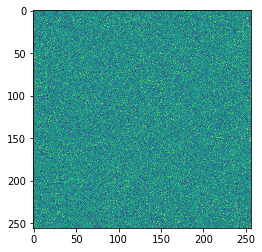

In [32]:
plt.imshow(X.squeeze())

tensor(0.2331, device='cuda:0', grad_fn=<AddBackward0>)
******************** 0 ********************
e 8e-05


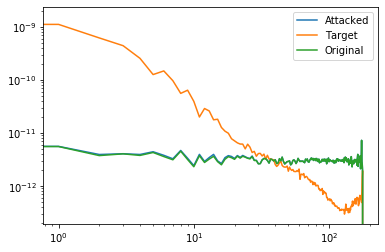

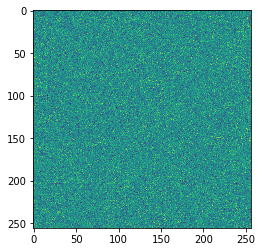

tensor(0.2215, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2115, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1895, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1770, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1625, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1473, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1327, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1091, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0719, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0375, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0086, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0219, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0085, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0219, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0085, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0218, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0084, device='cuda:0', grad_fn=<AddBack

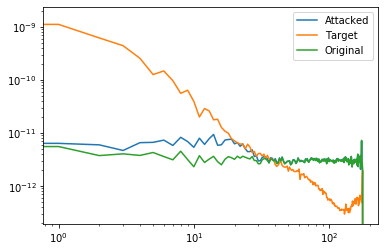

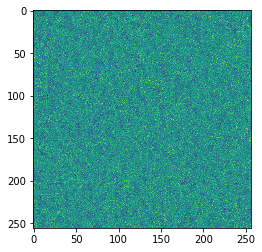

tensor(0.0213, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0049, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0181, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0061, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0181, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0061, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0181, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0061, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0181, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0061, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0181, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0061, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0181, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0061, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0180, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0061, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0180, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0061, device='cuda:0', grad_fn=<AddBack

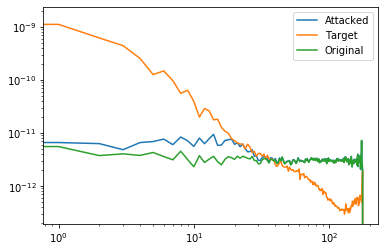

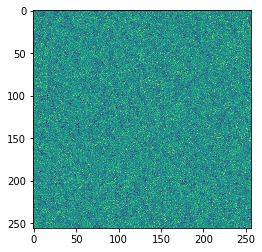

tensor(0.0179, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0043, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0175, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0043, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0174, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0043, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0173, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0043, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0172, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0043, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0171, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0043, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0171, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0042, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0170, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0042, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0170, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0042, device='cuda:0', grad_fn=<AddBack

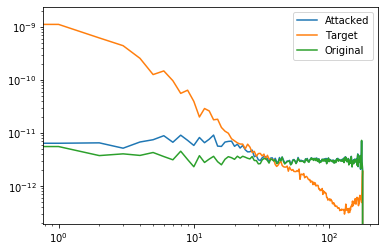

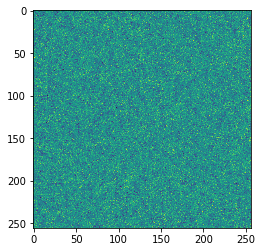

tensor(0.0160, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0035, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0132, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0034, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0132, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0034, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0131, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0034, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0131, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0034, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0131, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0034, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0130, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0034, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0130, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0034, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0130, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0034, device='cuda:0', grad_fn=<AddBack

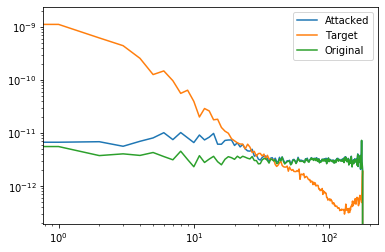

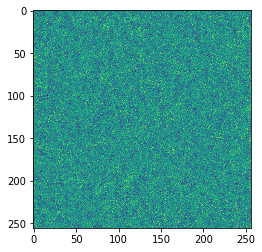

tensor(0.0125, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0027, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0105, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0027, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0105, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0027, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0105, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0027, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0105, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0027, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0105, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0027, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0104, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0027, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0104, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0027, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0104, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0027, device='cuda:0', grad_fn=<AddBack

In [33]:
X_robust, init_embed, robust_embed = compute_robust_map(model,\
                                  torch.Tensor(X).reshape((1, shape[0], shape[1])), \
                                torch.Tensor(gaussian_filter(targ_X,smooth)).reshape((1, shape[0], shape[1])) )#,\

In [34]:
X_robust = X_robust.to('cpu').detach().numpy().squeeze()
init_embed = init_embed.to('cpu').detach().numpy().squeeze()
robust_embed = robust_embed.to('cpu').detach().numpy().squeeze()

In [35]:
def get_embedding_2(x, model):
    x = scattering(x)

    x = x.view(1, model.K, model.input_size, model.input_size)#
############# UNCOMMENT ME ################
    x = model.init_conv(x)

    for i,l in enumerate(model.layers):
        #if i ==1:
        #    break
        x = l(x)
    
    return x

In [36]:
print(np.linalg.norm(init_embed-robust_embed))

0.010055442


In [37]:
X_robust.max(), X.max()

(0.17664015, 0.17583323993045408)

In [38]:
vmin = min(X.min(), targ_X.min())
vmax = max(X.max(), targ_X.max())

In [39]:
target_Y

array([[0.350059, 0.946085]])

In [40]:
model(scattering(torch.Tensor(gaussian_filter(targ_X.reshape((1, shape[0], shape[1])), 0)).to('cuda'))).to('cpu').detach().numpy()

array([[0.33389062, 0.93550557]], dtype=float32)

In [41]:
model(scattering(torch.Tensor(X_robust.reshape((1, shape[0], shape[1]))).to('cuda'))).to('cpu').detach().numpy()

array([[0.33642754, 0.9358386 ]], dtype=float32)

In [42]:
orig_s = scattering(torch.Tensor(X.reshape((1, shape[0], shape[1]))).to('cuda')).to('cpu').detach().numpy()
robust_s = scattering(torch.Tensor(X_robust.reshape((1, shape[0], shape[1]))).to('cuda')).to('cpu').detach().numpy()
targ_s = scattering(torch.Tensor(targ_X.reshape((1, shape[0], shape[1]))).to('cuda')).to('cpu').detach().numpy()

In [43]:
np.linalg.norm(orig_s-targ_s), np.linalg.norm(robust_s-targ_s)

(2.3906488, 2.409861)

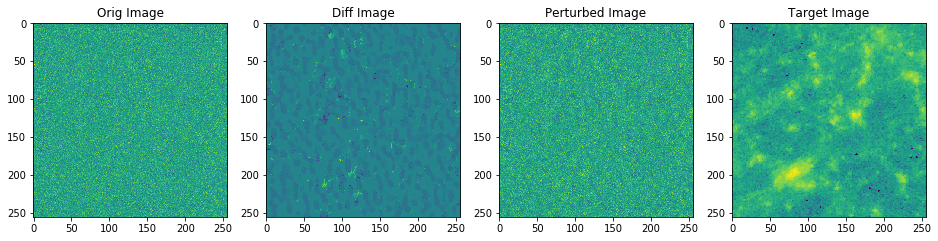

In [44]:
fig = plt.figure(figsize = (16,4))
plt.subplot(141)
plt.title('Orig Image')
plt.imshow(X.squeeze(), vmin = vmin, vmax= vmax)
plt.subplot(142)
plt.title('Diff Image')
plt.imshow(X_robust.squeeze()-X.squeeze() )#, vmin = 0.01*vmin, vmax= 0.01*vmax)
plt.subplot(143)
plt.title('Perturbed Image')
plt.imshow(X_robust.squeeze(), vmin = vmin, vmax= vmax)
plt.subplot(144)
plt.title('Target Image')
plt.imshow(targ_X.squeeze(), vmin = vmin, vmax= vmax)

(7219,)
(12435,)
(7160,)


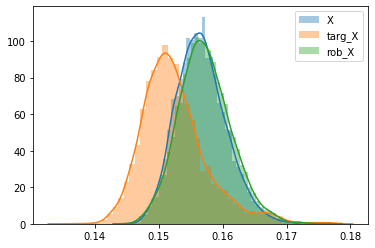

In [45]:
size = 1
orig_peaks = count_peaks(X.squeeze(), size = size)
print(orig_peaks.shape)
sns.distplot(orig_peaks,label = 'X');
targ_peaks = count_peaks(gaussian_filter(targ_X.squeeze(), smooth), size = size)
print(targ_peaks.shape)
sns.distplot(targ_peaks,label = "targ_X")
rob_peaks = count_peaks(X_robust.squeeze(), size = size)
print(rob_peaks.shape)
sns.distplot(rob_peaks,label = 'rob_X')
plt.legend(loc = 'best');

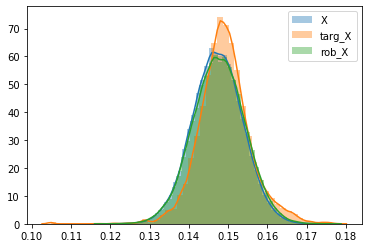

In [46]:
sns.distplot(X.flatten(), label = 'X')
sns.distplot(gaussian_filter(targ_X.flatten(), smooth), label = 'targ_X')
sns.distplot(X_robust.flatten(), label = 'rob_X')
plt.legend(loc='best')

---

In [47]:
attacked_ps = image_ps(X_robust.squeeze())
target_ps = image_ps(gaussian_filter(targ_X.squeeze(), smooth))
normal_ps = image_ps(X.squeeze())
diff_ps = image_ps((X_robust- X.squeeze()).squeeze())

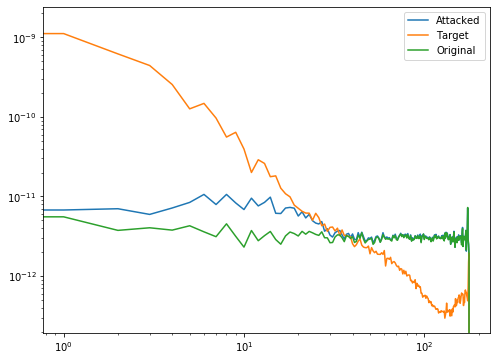

In [48]:
fig = plt.figure(figsize = (8, 6))
#plt.subplot(211)
plt.plot(attacked_ps, label = 'Attacked' )
plt.plot(target_ps, label = 'Target')
plt.plot(normal_ps, label = 'Original')
#plt.plot(diff_ps, label = 'Diff')

plt.legend(loc='best')
plt.loglog();
#plt.subplot(212)
#plt.title("Attacked/Normal")
#plt.plot(attacked_ps/normal_ps, label = 'Attacked')
#plt.plot(target_ps/normal_ps, label = 'Target')
#plt.legend(loc='best')
#plt.ylim([0.4, 6])
#plt.loglog();